quick start to see if this works - if so increase ts

#### download ERA5 data 
jan 25, 2021
12 hrs, 2 time steps

In [1]:
# Atmospheric River Evaluation using Aurora Forecasts (Jan 25, 2021)

from pathlib import Path
import cdsapi
import torch
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from aurora import Batch, Metadata, Aurora, rollout

In [2]:
# ------------------ SETUP ------------------
download_path = Path("~/downloads").expanduser()
download_path.mkdir(parents=True, exist_ok=True)

day = "2021-01-25"

c = cdsapi.Client()

# Static variables
date_key = day.replace("-", "")
if not (download_path / "static.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": ["geopotential", "land_sea_mask", "soil_type"],
            "year": "2021", "month": "01", "day": "25",
            "time": "00:00",
            "format": "netcdf",
        },
        str(download_path / "static.nc"),
    )

# Surface-level variables
surface_file = download_path / f"{day}-surface-level.nc"
if not surface_file.exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": ["2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind", "mean_sea_level_pressure"],
            "year": "2021", "month": "01", "day": "25",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(surface_file),
    )

# Atmospheric variables
atmos_file = download_path / f"{day}-atmospheric.nc"
if not atmos_file.exists():
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        {
            "product_type": "reanalysis",
            "variable": ["temperature", "u_component_of_wind", "v_component_of_wind", "specific_humidity", "geopotential"],
            "pressure_level": ["50", "100", "150", "200", "250", "300", "400", "500", "600", "700", "850", "925", "1000"],
            "year": "2021", "month": "01", "day": "25",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(atmos_file),
    )


2025-07-28 16:46:01,670 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


#### preprare input batch fro aurora

In [3]:
# ------------------ LOAD DATA ------------------
static_vars_ds = xr.open_dataset(download_path / "static.nc")
surf_vars_ds = xr.open_dataset(surface_file)
atmos_vars_ds = xr.open_dataset(atmos_file)

batch = Batch(
    surf_vars={
        "2t": torch.from_numpy(surf_vars_ds["t2m"].values[:2][None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[:2][None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[:2][None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[:2][None]),
    },
    static_vars={
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[:2][None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[:2][None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[:2][None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[:2][None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[:2][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[1],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

#### run aurora predictions

In [4]:
# ------------------ RUN AURORA ------------------
model = Aurora(use_lora=False)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")
model.eval().to("cuda")

with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model, batch, steps=2)]

model = model.to("cpu")

#### compute & plot IVT
Compute and plot IVT from both Aurora and ERA5 to visually compare atmospheric river structure

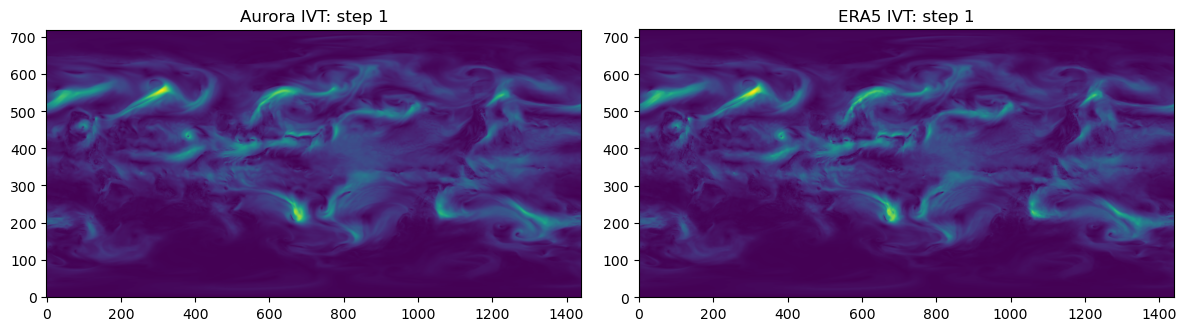

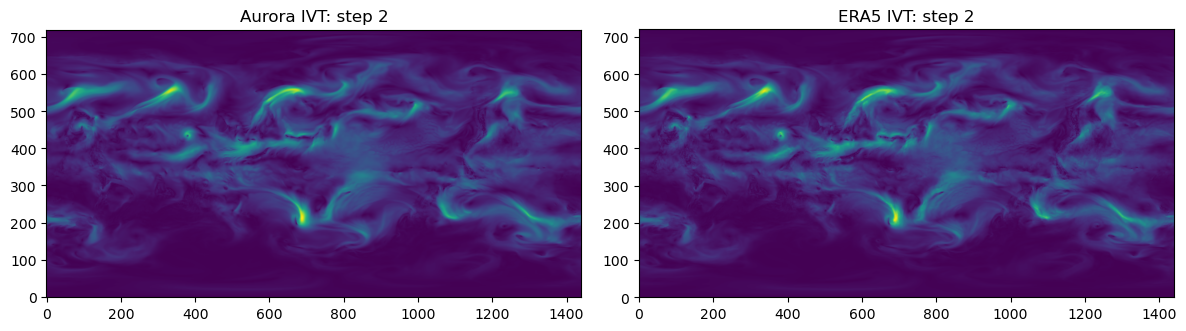

In [5]:
# ------------------ UTILITY: IVT ------------------
def compute_ivt(q, u, v, levels_hPa):
    g = 9.81
    levels_Pa = np.array(levels_hPa) * 100
    dp = -np.gradient(levels_Pa)
    qu = q * u
    qv = q * v
    ivt_u = np.sum(qu * dp[:, None, None] / g, axis=0)
    ivt_v = np.sum(qv * dp[:, None, None] / g, axis=0)
    ivt = np.sqrt(ivt_u**2 + ivt_v**2)
    return ivt, ivt_u, ivt_v

# ------------------ PLOT IVT ------------------
for i in range(2):
    pred = preds[i]
    ivt_pred, _, _ = compute_ivt(
        q=pred.atmos_vars["q"].squeeze().numpy(),
        u=pred.atmos_vars["u"].squeeze().numpy(),
        v=pred.atmos_vars["v"].squeeze().numpy(),
        levels_hPa=batch.metadata.atmos_levels
    )

    q = atmos_vars_ds["q"][2 + i].values
    u = atmos_vars_ds["u"][2 + i].values
    v = atmos_vars_ds["v"][2 + i].values
    ivt_obs, _, _ = compute_ivt(q, u, v, batch.metadata.atmos_levels)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].imshow(ivt_pred, origin="lower", cmap="viridis")
    axs[0].set_title(f"Aurora IVT: step {i+1}")
    axs[1].imshow(ivt_obs, origin="lower", cmap="viridis")
    axs[1].set_title(f"ERA5 IVT: step {i+1}")
    plt.tight_layout()
    plt.show()